# 基于Retinex的图像去雾算法

In [1]:
#coding:utf-8
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from scipy.misc import imread, imresize, imsave

In [19]:
def gen_gaussian_kernel(kw,kh,sigma):
    mask = np.zeros((kh,kw),dtype=np.float32)
    s2 = 2.0 * sigma * sigma
    hx = kw // 2
    hy = kh // 2
    
    for i in range(-hy,hy + 1):
        m = i + hy - 1
        for j in range(-hx,hx + 1):
            n = j + hx - 1
            v = np.exp((-1.0 * i * i + 1.0 * j * j) / s2)
            mask[m,n] = v
    return mask

In [54]:
src = cv2.cvtColor(cv2.imread('../datas/fog2.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [4]:
R = src[:,:,0]
G = src[:,:,1]
B = src[:,:,2]

N1,M1 = gray.shape

In [5]:
R0 = R.astype(np.float64)
Rlog = np.log(R0+1)
Rfft2 = np.fft.fft2(R0)

In [26]:
sigma = 250
F = gen_gaussian_kernel(M1,N1,250)
Efft = np.fft.fft2(F)

In [38]:
DR0 = Rfft2 * Efft
DR = np.fft.ifft2(DR0)

In [42]:
DRlog = np.log(DR + 1)
Rr = Rlog - DRlog
EXPRr = np.real(np.exp(Rr)) #提取实数 
MIN = np.amin(np.amin(EXPRr))
MAX = np.amax(np.amax(EXPRr))
EXPRr = (EXPRr - MIN)/(MAX - MIN) * 255
EXPRr = EXPRr.astype(np.uint8)
# EXPRr = cv2.adapthisteq(EXPRr)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
EXPRr = clahe.apply(EXPRr)

In [ ]:
plt.imshow(EXPRr,'gray')

In [ ]:
plt.imshow(R,'gray')

In [44]:
def retinex_single(src,sigma=250):
    N1,M1 = src.shape[0],src.shape[1]
    R0 = src.astype(np.float64).copy()
    Rlog = np.log(R0+1)
    Rfft2 = np.fft.fft2(R0)
    sigma = 250
    F = gen_gaussian_kernel(M1,N1,sigma)
    Efft = np.fft.fft2(F)
    DR0 = Rfft2 * Efft
    DR = np.fft.ifft2(DR0)
    DRlog = np.log(DR + 1)
    Rr = Rlog - DRlog
    EXPRr = np.real(np.exp(Rr)) #提取实数 
    MIN = np.amin(np.amin(EXPRr))
    MAX = np.amax(np.amax(EXPRr))
    EXPRr = (EXPRr - MIN)/(MAX - MIN) * 255
    EXPRr = EXPRr.astype(np.uint8)
    # EXPRr = cv2.adapthisteq(EXPRr)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    EXPRr = clahe.apply(EXPRr)
    return EXPRr

In [45]:
def retinex(src,sigma=250):
    dst = np.zeros_like(src)
    if len(src.shape) == 3:
        R = retinex_single(src[:,:,0],sigma)
        G = retinex_single(src[:,:,1],sigma)
        B = retinex_single(src[:,:,2],sigma)
        dst[:,:,0] = R
        dst[:,:,1] = G
        dst[:,:,2] = B
    elif len(src.shape) == 2:
        dst = retinex_single(src,sigma)
    else:
        pass
    return dst

In [55]:
dst = retinex(src)

Text(0.5,1,'Retinex Result')

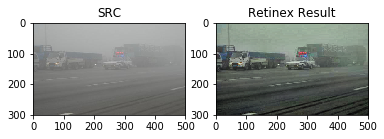

In [56]:
plt.subplot(121)
plt.imshow(src)
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst)
plt.title('Retinex Result')

参考：

[1]. https://blog.csdn.net/baimafujinji/article/details/73824787